# Load Data

In [182]:
hyperparameters = {'hidden_dim': 128, 'batch_size': 128, 'n1_gat_layers': 1, 'n2_gru_layers': 1, 'num_heads': 4, 'dropout': 0.04033931265087129, 'learning_rate': 0.00015574186652855083, 'pos_lambda': 0.5756532880616873, 'bios_hidden_dim': 32, 'pres_hidden_dim': 64, 'k': 5, 'num_clusters': 240}

In [183]:
import preprocess
import imp
imp.reload(preprocess)

data = preprocess.preprocess_pipeline(num_clusters=hyperparameters['num_clusters'])

1. Include only first admissions: N=32513
2. Exclusion by ages: N=25548
3. Include only patients who admitted for at least 24 hours: N=25168
4. Exclude patients who died within 54-hours of admission: N=24556


/home/bnet/kupershmidt/HML/preprocess.py:209: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pivot = pd.pivot_table(merged, index=['subject_id', 'hadm_id', pd.Grouper(key='charttime', freq=PREDICT_FREQ)],
/home/bnet/kupershmidt/HML/preprocess.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns=["mort_30day","prolonged_stay","readmission_30day"], axis=1, inplace=True)
/home/bnet/kupershmidt/HML/preprocess.py:273: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val.drop(columns=["mort_30day","prolonged_stay","readmission_30day"], axis=1, inplace=

Pooled embeddings shape: 24529
Number of subjects: 24529


# Datasets creation

In [184]:
data["prescriptions_train"].shape[0] == data["padded_tensor_train"].shape[0]

True

In [185]:
import Dataset
import imp
imp.reload(Dataset)
import torch
from torch.utils.data import DataLoader
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
k = hyperparameters['k']

train_labels = torch.tensor(data["y_train"][['mort_30day', 'prolonged_stay', 'readmission_30day']].values, dtype=torch.float32).to(DEVICE)
val_labels = torch.tensor(data["y_val"][['mort_30day', 'prolonged_stay', 'readmission_30day']].values, dtype=torch.float32).to(DEVICE)
test_labels = torch.tensor(data["y_test"][['mort_30day', 'prolonged_stay', 'readmission_30day']].values, dtype=torch.float32).to(DEVICE)


batch_size = hyperparameters['batch_size']
datasets = {x: Dataset.PatientDataset(d, y, core=data["padded_tensor_core"], padding_mask=m, padding_mask_core=data["padding_mask_core"], k=k ,notes=n, bios=b, prescriptions=p) for x, d, y, m, n, b, p in
        zip(['train', 'val', 'test'], [data["padded_tensor_train"], data["padded_tensor_val"], data["padded_tensor_test"]],
            [train_labels, val_labels, test_labels],
            [data["padding_mask_train"], data["padding_mask_val"], data["padding_mask_test"]],
            [torch.stack(data["notes_df_train"].embeddings.values.tolist()),
             torch.stack(data["notes_df_val"].embeddings.values.tolist()),
             torch.stack(data["notes_df_test"].embeddings.values.tolist())],
             [torch.tensor(data["bio_train"].values >= 1, dtype=torch.float32).to(DEVICE),
              torch.tensor(data["bio_val"].values >= 1, dtype=torch.float32).to(DEVICE),
              torch.tensor(data["bio_test"].values >= 1, dtype=torch.float32).to(DEVICE)],
              [torch.tensor(data["prescriptions_train"].values, dtype=torch.float32).to(DEVICE), 
              torch.tensor(data["prescriptions_val"].values, dtype=torch.float32).to(DEVICE), 
              torch.tensor(data["prescriptions_test"].values, dtype=torch.float32).to(DEVICE)])}
dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val', 'test']}

# Model Training

In [192]:
import Model 
import imp
imp.reload(Model)
model = Model.GraphGRUMortalityModel(input_dim=data["padded_tensor_train"].shape[2], hidden_dim=hyperparameters['hidden_dim'], 
                                     n1_gat_layers=1, n2_gru_layers=1, 
                                     X_core=data["padded_tensor_core"], num_of_bios=data["bio_train"].shape[1],
                                     num_prescriptions=data["prescriptions_train"].shape[-1], 
                                     bios_hidden_dim=hyperparameters['bios_hidden_dim'], pres_hidden_dim=hyperparameters['pres_hidden_dim'], 
                                     core_padding_mask=data["padding_mask_core"], num_heads=hyperparameters['num_heads'], 
                                     dropout=hyperparameters['dropout'], seq_len=data["padded_tensor_train"].shape[1], k=k, gnn_flag=True).to(DEVICE)
torch.manual_seed(1234)
model.train_all(dataloaders, datasets, epochs=10, learning_rate=hyperparameters['learning_rate'], pos_lambda=hyperparameters['pos_lambda'])
print("Training completed. Validating on test set...")

model.validate(dataloaders['test'], datasets['test'])
#print(f'Test Accuracy in model: {acc:.4f}, AUC: {auc:.4f}, ב

/home/bnet/kupershmidt/anaconda3/envs/spider/lib/python3.10/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.04033931265087129 and num_layers=1
  warnings.warn(
/home/bnet/kupershmidt/anaconda3/envs/spider/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Pos weight 0: 7.5538
Pos weight 1: 1.1253
Pos weight 2: 23.8500
Starting epoch 1/10
100%|██████████| 152/152 [01:38<00:00,  1.54it/s]
Epoch 1/10, Loss: 2.3080
100%|██████████| 20/20 [00:12<00:00,  1.57it/s]
Val Mortality - AUC: 0.7778 | AP: 0.3146
Val Prolonged LOS - AUC: 0.7530 | AP: 0.7294
Val Readmission - AUC: 0.6536 | AP: 0.0702
Best model updated
Starting epoch 2/10
100%|██████████| 152/152 [01:37<00:00,  1.56it/s]
Epoch 2/10, Loss: 2.1612
100%|██████████| 20/20 [00:12<00:00,  1.64it/s]
Val Mortality - AUC: 0.8079 | AP: 0.3548
Val Prolonged LOS - AUC: 0.7782 | AP: 0.7569
Val Readmission - AUC: 0.6631 | AP: 0.0739
Best model updated
Starting epoch 3/10
100%|██████████| 152/152 [01:36<00:00,  1.57it/s]
Epoch 3/10, Loss: 2.1093
100%|██████████| 20/20 [00:12<00:00,  1.65it/s]
Val Mortality - AUC: 0.8213 | AP: 0.3767
Val Prolonged LOS - AUC: 0.7855 | AP: 0.7641
Val Readmission - AUC: 0.6622 | AP: 0.0764
Best model updated
Starting epoch 4/10
100%|██████████| 152/152 [01:37<00:00,  1.5

(0.8568581273466077,
 0.515078960384729,
 0.8172192698321904,
 0.7985483458593484,
 0.6397925538757354,
 0.08593987171430639)

In [193]:
res = model.validate(dataloaders['test'], datasets['test'])

print(f"Test Mortality: AUC-ROC: {res[0]:.2f}  AP: {res[1]:.2f}")
print(f"Test Prolonged Stay: AUC-ROC: {res[2]:.2f}  AP: {res[3]:.2f}")
print(f"Test Readmission: AUC-ROC: {res[4]:.2f}  AP: {res[5]:.2f}")

100%|██████████| 20/20 [00:12<00:00,  1.56it/s]
Test Mortality: AUC-ROC: 0.86  AP: 0.52
Test Prolonged Stay: AUC-ROC: 0.82  AP: 0.80
Test Readmission: AUC-ROC: 0.64  AP: 0.09


In [ ]:
torch.save(model, 'model.pt')

model = torch.load('model.pt')
baseline_model = torch.load('baseline_model.pt')

/tmp/ipykernel_1070811/442818902.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pt')
/tmp/ipykernel_1070811/442818902.py:4: FutureWarning: You

Generating predictions on test set...
100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


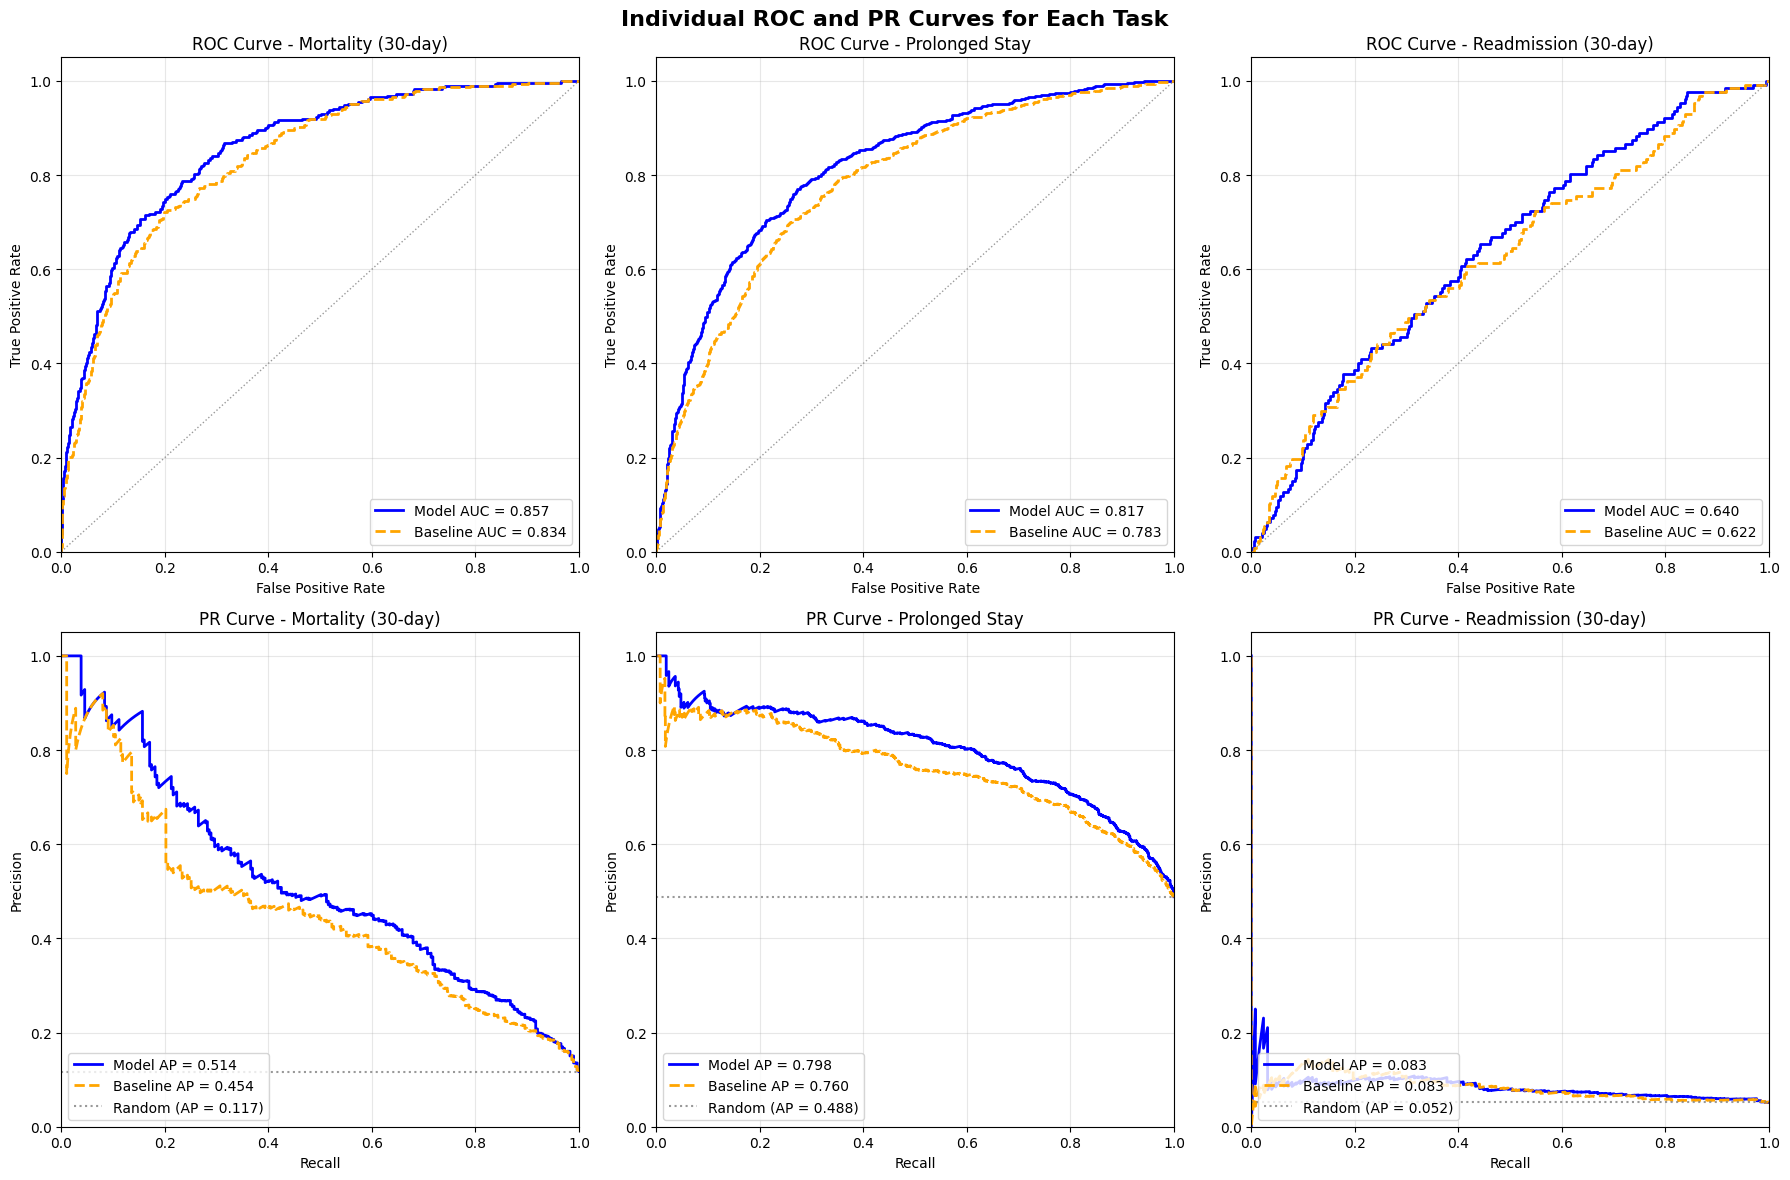

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# Additional Analysis: Individual ROC and PR curves for each task
print("Generating predictions on test set...")
y_trues, y_preds = model.validate(dataloaders['test'], datasets['test'], return_predictions=True)

# Define task names for better visualization
task_names = ['Mortality (30-day)', 'Prolonged Stay', 'Readmission (30-day)']

# Convert to numpy arrays for easier handling
for i in range(3):
    y_trues[i] = np.array(y_trues[i])
    y_preds[i] = np.array(y_preds[i])

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Individual ROC and PR Curves for Each Task', fontsize=16, fontweight='bold')

# Colors: model in blue/green/red, baseline in orange
model_colors = 'blue'
baseline_color = 'orange'

# Load baseline model predictions
# Assumes baseline_model is loaded and has a .validate method like the main model
y_trues_baseline, y_preds_baseline = baseline_model.validate(dataloaders['test'], datasets['test'], return_predictions=True)
for i in range(3):
    y_trues_baseline[i] = np.array(y_trues_baseline[i])
    y_preds_baseline[i] = np.array(y_preds_baseline[i])

for i, task_name in enumerate(task_names):
    # Model
    y_true = y_trues[i]
    y_pred = y_preds[i]
    # Baseline
    y_true_base = y_trues_baseline[i]
    y_pred_base = y_preds_baseline[i]
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    fpr_base, tpr_base, _ = roc_curve(y_true_base, y_pred_base)
    roc_auc_base = auc(fpr_base, tpr_base)
    
    axes[0, i].plot(fpr, tpr, color=model_colors, lw=2, 
                   label=f'Model AUC = {roc_auc:.3f}')
    axes[0, i].plot(fpr_base, tpr_base, color=baseline_color, lw=2, linestyle='--', 
                   label=f'Baseline AUC = {roc_auc_base:.3f}')
    axes[0, i].plot([0, 1], [0, 1], color='gray', lw=1, linestyle=':', alpha=0.8)
    axes[0, i].set_xlim([0.0, 1.0])
    axes[0, i].set_ylim([0.0, 1.05])
    axes[0, i].set_xlabel('False Positive Rate')
    axes[0, i].set_ylabel('True Positive Rate')
    axes[0, i].set_title(f'ROC Curve - {task_name}')
    axes[0, i].legend(loc="lower right")
    axes[0, i].grid(True, alpha=0.3)
    
    # PR Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)
    precision_base, recall_base, _ = precision_recall_curve(y_true_base, y_pred_base)
    pr_auc_base = auc(recall_base, precision_base)
    baseline = np.mean(y_true)
    
    axes[1, i].plot(recall, precision, color=model_colors, lw=2, 
                   label=f'Model AP = {pr_auc:.3f}')
    axes[1, i].plot(recall_base, precision_base, color=baseline_color, lw=2, linestyle='--', 
                   label=f'Baseline AP = {pr_auc_base:.3f}')
    axes[1, i].axhline(y=baseline, color='gray', linestyle=':', alpha=0.8, 
                      label=f'Random (AP = {baseline:.3f})')
    axes[1, i].set_xlim([0.0, 1.0])
    axes[1, i].set_ylim([0.0, 1.05])
    axes[1, i].set_xlabel('Recall')
    axes[1, i].set_ylabel('Precision')
    axes[1, i].set_title(f'PR Curve - {task_name}')
    axes[1, i].legend(loc="lower left")
    axes[1, i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [195]:
# Calibration Analysis
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import seaborn as sns

def calculate_ece(y_true, y_prob, n_bins=10):
    """
    Calculate Expected Calibration Error (ECE)
    """
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_prob[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

def calculate_mce(y_true, y_prob, n_bins=10):
    """
    Calculate Maximum Calibration Error (MCE)
    """
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    mce = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = y_true[in_bin].mean()
            avg_confidence_in_bin = y_prob[in_bin].mean()
            mce = max(mce, np.abs(avg_confidence_in_bin - accuracy_in_bin))
    
    return mce

def plot_calibration_curve(y_true, y_prob, task_name, n_bins=10, ax=None):
    """
    Plot calibration curve with reliability diagram
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Calculate calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_prob, n_bins=n_bins, strategy='uniform'
    )
    
    # Plot reliability diagram
    ax.plot(mean_predicted_value, fraction_of_positives, "s-", 
            label=f'{task_name} (ECE: {calculate_ece(y_true, y_prob, n_bins):.3f})',
            linewidth=2, markersize=8)
    
    # Plot perfect calibration line
    ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated", linewidth=2)
    
    # Calculate and display metrics
    ece = calculate_ece(y_true, y_prob, n_bins)
    mce = calculate_mce(y_true, y_prob, n_bins)
    brier = brier_score_loss(y_true, y_prob)
    
    ax.set_xlabel('Mean Predicted Probability', fontsize=12)
    ax.set_ylabel('Fraction of Positives', fontsize=12)
    ax.set_title(f'Calibration Curve - {task_name}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add metrics as text
    metrics_text = f'ECE: {ece:.3f}\nMCE: {mce:.3f}\nBrier Score: {brier:.3f}'
    ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, 
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=10)
    
    return ax, ece, mce, brier

print("Calibration analysis functions loaded successfully!")


Calibration analysis functions loaded successfully!


In [196]:
# Generate predictions for calibration analysis
print("Generating predictions for calibration analysis...")

# Get predictions from both models
y_trues_model, y_preds_model = model.validate(dataloaders['test'], datasets['test'], return_predictions=True)

# Convert to numpy arrays
task_names = ['Mortality (30-day)', 'Prolonged Stay', 'Readmission (30-day)']
model_predictions = {}
true_labels = {}

for i, task_name in enumerate(task_names):
    model_predictions[task_name] = np.array(y_preds_model[i])
    true_labels[task_name] = np.array(y_trues_model[i])


Generating predictions for calibration analysis...
100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


In [197]:
# Calculate calibration metrics for all tasks
print("Calculating calibration metrics...")

calibration_metrics = {}

for task_name in task_names:
    print(f"\n{task_name}:")
    print("=" * 50)
    
    # Model metrics
    model_ece = calculate_ece(true_labels[task_name], model_predictions[task_name])
    model_mce = calculate_mce(true_labels[task_name], model_predictions[task_name])
    model_brier = brier_score_loss(true_labels[task_name], model_predictions[task_name])
    
    calibration_metrics[task_name] = {
        'model': {'ece': model_ece, 'mce': model_mce, 'brier': model_brier},
    }
    
    print(f"Model:")
    print(f"  ECE (Expected Calibration Error): {model_ece:.4f}")
    print(f"  MCE (Maximum Calibration Error): {model_mce:.4f}")
    print(f"  Brier Score: {model_brier:.4f}")
    
    # Interpretation
    if model_ece < 0.05:
        ece_interpretation = "Excellent calibration"
    elif model_ece < 0.1:
        ece_interpretation = "Good calibration"
    elif model_ece < 0.2:
        ece_interpretation = "Moderate calibration"
    else:
        ece_interpretation = "Poor calibration"
    
    print(f"  Model calibration quality: {ece_interpretation}")

print("\nCalibration metrics calculated successfully!")


Calculating calibration metrics...

Mortality (30-day):
Model:
  ECE (Expected Calibration Error): 0.0155
  MCE (Maximum Calibration Error): 0.3006
  Brier Score: 0.0781
  Model calibration quality: Excellent calibration

Prolonged Stay:
Model:
  ECE (Expected Calibration Error): 0.0232
  MCE (Maximum Calibration Error): 0.0661
  Brier Score: 0.1746
  Model calibration quality: Excellent calibration

Readmission (30-day):
Model:
  ECE (Expected Calibration Error): 0.0013
  MCE (Maximum Calibration Error): 0.0319
  Brier Score: 0.0486
  Model calibration quality: Excellent calibration

Calibration metrics calculated successfully!


Creating calibration plots...


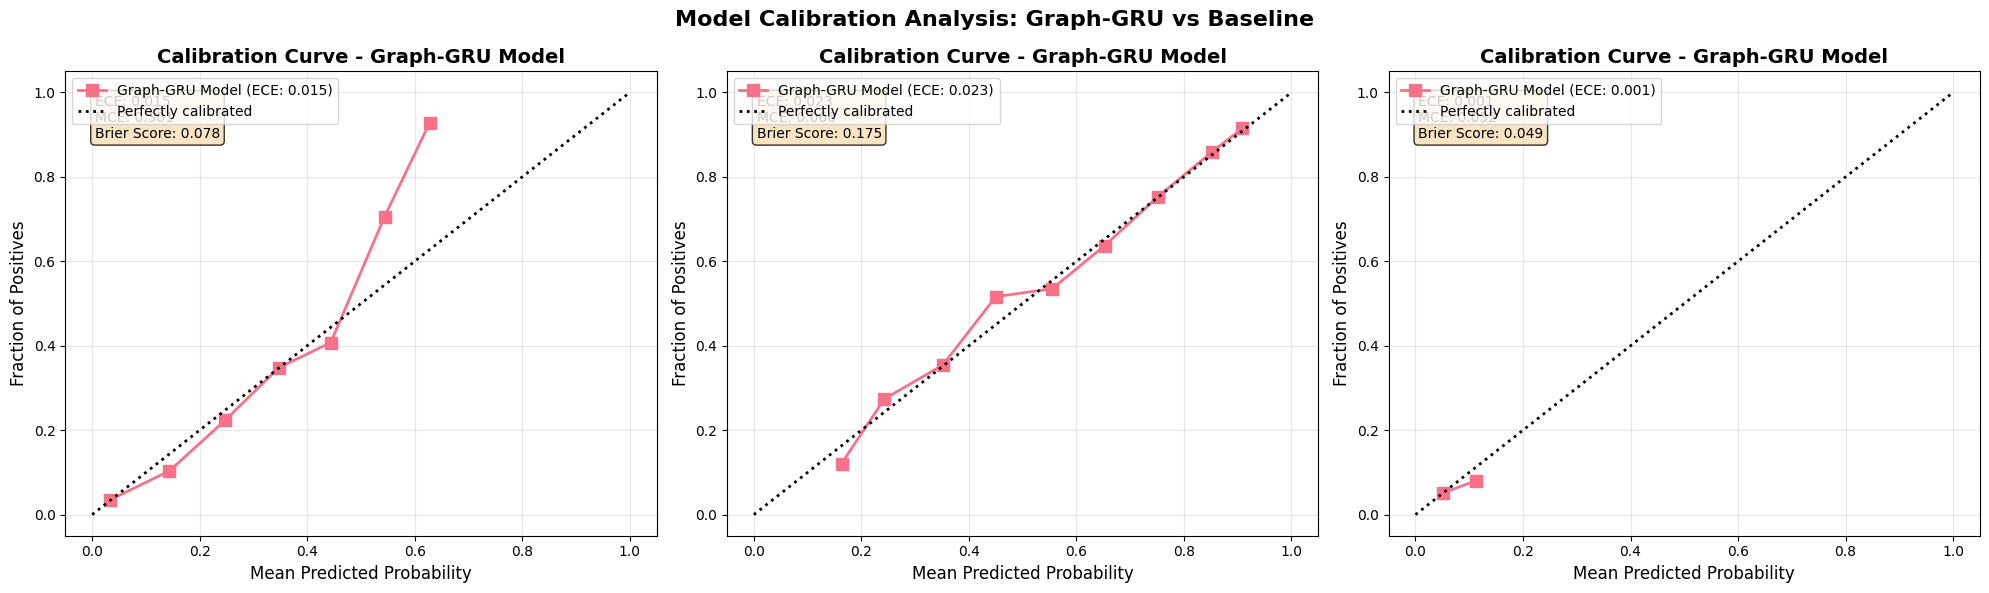

Calibration plots created successfully!


In [198]:
# Create comprehensive calibration plots
print("Creating calibration plots...")

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a comprehensive calibration plot
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Model Calibration Analysis: Graph-GRU vs Baseline', fontsize=16, fontweight='bold')

colors = ['#1f77b4', '#ff7f0e']  # Blue for model, Orange for baseline
model_color = colors[0]

for i, task_name in enumerate(task_names):
    # Top row: Model calibration curves
    ax_model = axes[i]
    plot_calibration_curve(true_labels[task_name], model_predictions[task_name], 
                          f'Graph-GRU Model', ax=ax_model, n_bins=10)
plt.tight_layout()
plt.show()

print("Calibration plots created successfully!")


In [205]:
# feature importance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

X = dataloaders['val'], datasets['val']
background = next(iter(dataloaders['val']))  # get a batch from val dataloader
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(X)


TypeError: GraphGRUMortalityModel.forward() takes 7 positional arguments but 8 were given

<!-- 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]
Test Mortality: AUC-ROC: 0.85  AP: 0.52
Test Prolonged Stay: AUC-ROC: 0.82  AP: 0.80
Test Readmission: AUC-ROC: 0.62  AP: 0.08 -->

<!-- Test Mortality: AUC-ROC: 0.87  AP: 0.52
Test Prolonged Stay: AUC-ROC: 0.83  AP: 0.81
Test Readmission: AUC-ROC: 0.62  AP: 0.08 -->